In [2]:
###Load packages###
import pandas as pd
import os
import ast
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns
from doctest import debug



###Load cleaned dataset###

#Set file paths
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'Study2.0'
cleandir = os.path.join(topdir, f'data/{study}/Cleaned')
outputdir = os.path.join(topdir, f'Analysis/{study}')
debug = 0

#Read in cleaned data (from cleaning scripts)
accomodate_path = os.path.join(cleandir, f'{study}Accommodate.csv')
predict_path   = os.path.join(cleandir, f'{study}Predict.csv')

df_accommodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accommodate['task'] = 'accommodate'
df_predict['task']   = 'predict'



print("Accomodate columns:", df_accommodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accomodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_wing', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'color_high', 'color_low', 'wing_high', 'wing_low', 'tail_high', 'tail_low', 'wing_discrete_slider.response', 'wing_direction_slider.response', 'wing_continuous_slider.response', 'color_discrete_slider.response', 'color_direction_slider.response', 'color_continuous_slider.response', 'tail_discrete_slider.response', 'tail_direction_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'training_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_wing', 'training_color', 'testing_categories', 'co

In [3]:
#Converting string representations of lists back to lists

def parse_list_column(x):
    """take column entries that are strings representing lists and convert them to actual lists"""
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            return ast.literal_eval(x)
        else:
            return [x]
    return []
for col in ['training_tail', 'training_wing', 'training_color', 'training_image_order', 'training_categories', 'testing_categories']:
    df_accommodate[col] = df_accommodate[col].apply(parse_list_column)
    df_predict[col]   = df_predict[col].apply(parse_list_column)

df_accommodate['testing_responses'] = df_accommodate['testing_responses'].apply(ast.literal_eval)
df_accommodate['food_amount'] = df_accommodate['food_amount'].apply(ast.literal_eval)
df_accommodate['testing_image_order'] = df_accommodate['testing_image_order'].apply(ast.literal_eval)
df_predict['testing_responses'] = df_predict['testing_responses'].apply(ast.literal_eval)
df_predict['food_amount'] = df_predict['food_amount'].apply(ast.literal_eval)
df_predict['testing_image_order'] = df_predict['testing_image_order'].apply(ast.literal_eval)
#Combine the dataframes and create an arbitrary column for participant numbering (the yoked orders are already stored in 'conditionOrder')
df_combined = pd.concat([df_accommodate, df_predict], ignore_index=True)
df_combined['participant'] = range(1, len(df_combined) + 1)



In [4]:
#Create map from short codes to feature descriptions

wing_map = {
    'wings': 't',
    'paws': 'n'
}

color_map = {
    'blue': 'b',
    'yellow': 'y'
}

tail_map = {
    'curly': 'c',
    'straight': 's'
}


feature_maps = {
    'wing': wing_map,
    'color': color_map,
    'tail': tail_map
}


In [5]:
#Compute feature importance scores

from doctest import debug


def compute_feature_importance_from_df(df):
    """
    Compute numeric feature importance scores(-7 to 7) for each participant,
    based on the saved slider_responses and the feature _high/_low mapping.
    This is computed based on whether a feature was really relevant (positive sign) or irrelevant (negative sign).
    0 = no response or feature was not thought to be relevant
    columns:
      - wings_discrete_slider.response, wings_direction_slider.response, wings_continuous_slider.response
      - color_discrete_slider.response, ...
      - tail_discrete_slider.response, ...
      - wings_high, wings_low, color_high, color_low, tail_high, tail_low
    """
    features = ['wing', 'color', 'tail']
    
    def compute_row_importance(row, feat):
        disc = row[f'{feat}_discrete_slider.response']
        dirc = row[f'{feat}_direction_slider.response']
        cont = row[f'{feat}_continuous_slider.response']

        #If they said a feature wasn't relevant, then importance is 0
        
        if disc == 'No' or pd.isna(disc):
            return 0.0
        
        # Make sure continuous slider value exists, if not, set it to 0
        cont_val = float(cont) if not pd.isna(cont) else 0.0

        # Get mapping from long to short feature name
        mapping = feature_maps.get(feat, {})

        # Normalize strings: strip whitespace, collapse multiple spaces, lower-case
        def normalize_str(s):
            """Strip leading/trailing whitespace and collapse internal multiple spaces."""

            if isinstance(s, str):
                return " ".join(s.split()).lower()
            return ""
        

        #Name of features need to be normalized for comparison using the mapping
        dirc_norm = normalize_str(dirc)

        #Get internal short code for selected feature direction
        internal_dirc = mapping.get(dirc_norm, None)
        
        high_val = normalize_str(row[f'{feat}_high'])
        low_val  = normalize_str(row[f'{feat}_low'])
        

        
        # Debug print statement (make sure mappings look right)
        debug = True
        if debug:
            print('response:', repr(dirc_norm), 'internal:', repr(internal_dirc), 
                'high:', repr(high_val), 'low:', repr(low_val))
            

        #If they correctly selected the high feature, assign positive sign
        if internal_dirc == high_val:
            sign = 1
        #If they incorrectly selected the low feature, assign negative sign
        elif internal_dirc == low_val:
            if debug:
                print('in negative')
            sign = -1
        else:
            if debug:
                print('in empty')
            sign = 0
            cont_val = 0.0

        # Add sign to continuous value
        importance = cont_val * sign

        return importance

    
    # Compute for each feature
    for feat in features:
        df[f'{feat}_importance'] = df.apply(lambda row: compute_row_importance(row, feat), axis=1)
    
    return df

df_combined = compute_feature_importance_from_df(df_combined)
if debug:
    print(df_combined['wing_importance'])

response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 't' low: 'n'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 't' low: 'n'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 'n' low: 't'
in negative
response: 'paws' internal: 'n' high: 't' low: 'n'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 'n' low: 't'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n'

In [14]:
print(df_combined)

     participant                                         free_texts  \
0              1  ['It is small and did not go so far to find fo...   
1              2  ["with front paws, it's less efficient to trav...   
2              3  ["Hard to say as it's the first sperk I've see...   
3              4  ['They have wings', 'they have a tail', 'they ...   
4              5  ['It has paws, is yellow and has a straight ta...   
..           ...                                                ...   
413          414                                                NaN   
414          415                                                NaN   
415          416                                                NaN   
416          417                                                NaN   
417          418                                                NaN   

                   feedback  \
0                        []   
1                        []   
2                        []   
3                      

In [15]:
# Check unique values
for feat in ['tail', 'wing', 'color']:
    print(f"--- {feat} ---")
    print("feature_value unique:", df_long_feat.loc[df_long_feat['feature']==feat,'feature_value'].unique())
    print(f"{feat}_high unique:", df_long_feat[f"{feat}_high"].unique())


--- tail ---
feature_value unique: ['N' 'T']
tail_high unique: ['C' 'S']
--- wing ---
feature_value unique: ['C' 'S']
wing_high unique: ['T' 'N']
--- color ---
feature_value unique: ['B' 'Y']
color_high unique: ['Y' 'B']


In [ ]:

#Define importance raint columns
importance_cols = [f"{feat}_importance" for feat in ['tail', 'color', 'wing']]
#Get relevant columns
cols_needed = ['task', 'training_image_order', 'food_amount', 'conditionOrder',
                'color_high', 'tail_high', 'wing_high', 'irrelevant_dim', 'relevant_dim_1', 'relevant_dim_2'] + importance_cols
#Copy overarching data frame
df_sub = df_combined[cols_needed].copy()
df_long = df_sub.explode(['training_image_order', 'food_amount']).rename(columns={'training_image_order': 'item'})
#print(df_long.head(30))
   # Mean food amount per item
df_items = (
    df_long.groupby(['task', 'conditionOrder', 'item'], as_index=False)
            .agg(
                food_amount=('food_amount', 'mean'),
                color_high=('color_high', 'first'),
                tail_high=('tail_high', 'first'),
                wing_high=('wing_high', 'first'),
                **{f"{feat}_importance": (f"{feat}_importance", 'first') for feat in ['tail', 'color', 'wing']}))
df_items[['wing_val', 'color_val', 'tail_val']] = (
    df_items['item'].str.split('_', expand=True)
)
#print(df_items)
df_long_feat = df_items.melt(
    id_vars=['task', 'conditionOrder', 'food_amount',
             'tail_high', 'color_high', 'wing_high'],
    value_vars=['tail_val', 'color_val', 'wing_val'],
    var_name='feature',
    value_name='feature_value'
)
df_long_feat['feature'] = df_long_feat['feature'].str.replace('_val', '')
df_long_feat['high_or_low'] = df_long_feat.apply(
    lambda r: (
        'high'
        if r['feature_value'] == r[f"{r['feature']}_high"]
        else 'low'
    ),
    axis=1
)
hl = (
    df_long_feat
    .groupby(['task', 'conditionOrder', 'feature', 'high_or_low'])
    .agg(food_mean=('food_amount', 'mean'))
    .unstack()
)
hl['high_minus_low'] = (
    hl['food_mean']['high'] - hl['food_mean']['low']
)
df_hl = (
    hl.reset_index()
      [['task', 'conditionOrder', 'feature', 'high_minus_low']]
)
importance_long = (
    df_items
    .groupby(['task', 'conditionOrder'], as_index=False)
    .agg(
        tail_importance=('tail_importance', 'first'),
        color_importance=('color_importance', 'first'),
        wing_importance=('wing_importance', 'first')
    )
    .melt(
        id_vars=['task', 'conditionOrder'],
        var_name='feature',
        value_name='importance'
    )
)

importance_long['feature'] = importance_long['feature'].str.replace('_importance', '')
print(importance_long)
print(df_hl)
df_hl.columns = df_hl.columns.get_level_values(0)
df_hl_full = df_hl.merge(
    importance_long,
    on=['task', 'conditionOrder', 'feature'],
    how='left'
)
df_hl_full['high_minus_low'] = pd.to_numeric(
    df_hl_full['high_minus_low'], errors='coerce'
)

df_hl_full = df_hl_full.dropna(subset=['high_minus_low'])
print(df_hl_full)


             task  conditionOrder feature  importance
0     accommodate               1    tail         6.0
1     accommodate               3    tail         0.0
2     accommodate               4    tail         0.0
3     accommodate               5    tail         3.0
4     accommodate               6    tail         3.0
...           ...             ...     ...         ...
1249      predict             216    wing        -4.0
1250      predict             217    wing         5.0
1251      predict             218    wing         4.0
1252      predict             219    wing        -3.0
1253      predict             220    wing         4.0

[1254 rows x 4 columns]
                    task conditionOrder feature high_minus_low
high_or_low                                                   
0            accommodate              1   color           1.25
1            accommodate              1    tail            NaN
2            accommodate              1    wing            NaN
3           

<Figure size 700x500 with 0 Axes>

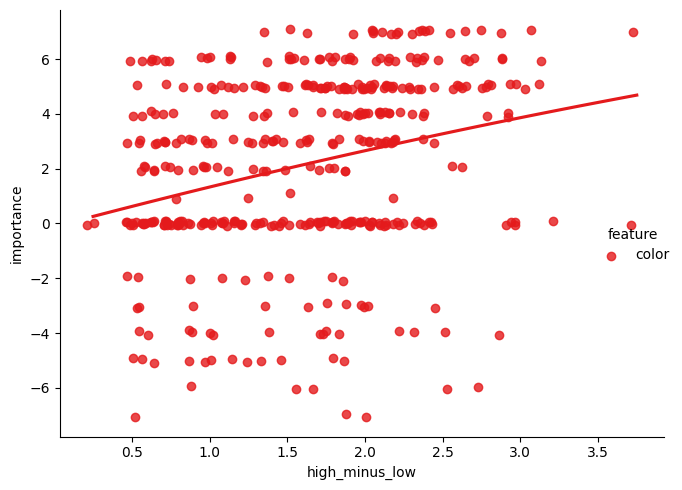

In [7]:
# Scatter with regression lines per task
plt.figure(figsize=(7,5))
sns.lmplot(
    data=df_hl_full,
    x='high_minus_low',
    y='importance',
    hue='feature',       # color by task
    height=5,
    aspect=1.2,
    ci=None,       
    markers='o',
    palette='Set1',
    x_jitter=0.05, 
    y_jitter=0.1,
    order=2
)

plt.tight_layout()
#plt.savefig(os.path.join(outputdir, 'Figure6_SupplementaryIrrelevantFeatureImportanceVsActualAmount.png'), dpi=300)
plt.show()